<a href="https://colab.research.google.com/github/Abhiraj36/Compression01/blob/main/CNN_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
!pip install scikit-image wandb

from skimage.metrics import structural_similarity as ssim
import numpy as np
import time


import wandb
wandb.init(
    project="skip-autoencoder-compression",
    config={
        "epochs_ae": 5,
        "epochs_comp": 10,
        "batch_size": 128,
        "lr": 0.001,
        "dataset": "CIFAR10"
    }
)
config = wandb.config


# Ensure output directory exists
os.makedirs("output_images", exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Skip-Connected Autoencoder

class SkipAutoencoder(nn.Module):
    def __init__(self):
        super(SkipAutoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True))
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(inplace=True))  # 16x16
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(inplace=True))  # 8x8

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(inplace=True))  # 16x16
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1), nn.ReLU(inplace=True))  # 32x32
        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 3, 3, padding=1), nn.Tanh())

    def forward(self, x):
        e1 = self.enc1(x)  # [B, 64, 32, 32]
        e2 = self.enc2(e1) # [B, 128, 16, 16]
        e3 = self.enc3(e2) # [B, 256, 8, 8]

        d1 = self.dec1(e3)                # [B, 128, 16, 16]
        d1_cat = torch.cat([d1, e2], 1)   # [B, 256, 16, 16]

        d2 = self.dec2(d1_cat)           # [B, 64, 32, 32]
        d2_cat = torch.cat([d2, e1], 1)  # [B, 128, 32, 32]

        out = self.dec3(d2_cat)          # [B, 3, 32, 32]

        return out, e3  # output and latent



# Latent Compressor

class LatentCompressor(nn.Module):
    def __init__(self, input_channels=256):
        super(LatentCompressor, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=3, stride=2, padding=1),  # 8x8 → 4x4
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),              # 4x4 → 2x2
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1),     # 2x2 → 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1),    # 4x4 → 8x8
            nn.ReLU(),
        )

        # Final projection to match the latent shape exactly (in case of residual mismatch)
        self.project = nn.Conv2d(256, input_channels, kernel_size=1)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        projected = self.project(out)
        return projected


# Data Preparation

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1,1]
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=16, shuffle=False)


# Initialize Models

autoencoder = SkipAutoencoder().to(device)
latent_compressor = LatentCompressor().to(device)


# Train Autoencoder First (optional: or load pretrained)

ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
ae_criterion = nn.MSELoss()

print("\nTraining Autoencoder...")
autoencoder.train()
for epoch in range(config.epochs_ae):
    total_loss = 0.0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        ae_optimizer.zero_grad()
        recon, _ = autoencoder(imgs)
        loss = ae_criterion(recon, imgs)
        loss.backward()
        ae_optimizer.step()
        total_loss += loss.item() * imgs.size(0)

    avg_loss = total_loss / len(trainloader.dataset)
    print(f"Autoencoder Epoch [{epoch+1}/{config.epochs_ae}], Loss: {avg_loss:.6f}")

    #  Log to wandb
    wandb.log({
        "train/ae_loss": avg_loss,
        "epoch": epoch + 1,
        "train/recon_sample": [wandb.Image(recon[0].cpu(), caption="Reconstructed"),
                               wandb.Image(imgs[0].cpu(), caption="Original")]
    })



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abhirajaryan (abhirajaryan-sarla-birla-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]



Training Autoencoder...
Autoencoder Epoch [1/5], Loss: 0.004777
Autoencoder Epoch [2/5], Loss: 0.000550
Autoencoder Epoch [3/5], Loss: 0.000342
Autoencoder Epoch [4/5], Loss: 0.000252
Autoencoder Epoch [5/5], Loss: 0.000198


In [2]:

# Train Latent Compressor

latent_compressor.train()
comp_optimizer = optim.Adam(latent_compressor.parameters(), lr=0.001)
comp_criterion = nn.MSELoss()

print("\nTraining Latent Compressor...")
latent_compressor.train()
for epoch in range(config.epochs_comp):
    total_loss = 0.0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        with torch.no_grad():
            _, e3 = autoencoder(imgs)
        comp_optimizer.zero_grad()
        recon_e3 = latent_compressor(e3)
        loss = comp_criterion(recon_e3, e3)
        loss.backward()
        comp_optimizer.step()
        total_loss += loss.item() * imgs.size(0)

    avg_loss = total_loss / len(trainloader.dataset)
    print(f"Compressor Epoch [{epoch+1}/{config.epochs_comp}], Loss: {avg_loss:.6f}")

    #  Log to wandb
    wandb.log({
        "train/compressor_loss": avg_loss,
        "epoch": config.epochs_ae + epoch + 1
    })




Training Latent Compressor...
Compressor Epoch [1/10], Loss: 0.010445
Compressor Epoch [2/10], Loss: 0.004532
Compressor Epoch [3/10], Loss: 0.003327
Compressor Epoch [4/10], Loss: 0.002792
Compressor Epoch [5/10], Loss: 0.002474
Compressor Epoch [6/10], Loss: 0.002219
Compressor Epoch [7/10], Loss: 0.002033
Compressor Epoch [8/10], Loss: 0.001898
Compressor Epoch [9/10], Loss: 0.001805
Compressor Epoch [10/10], Loss: 0.001706


In [3]:
wandb.watch(autoencoder, log="all", log_freq=100)
wandb.watch(latent_compressor, log="all", log_freq=100)


In [4]:

import time
from torchvision.utils import save_image

# Evaluation & Saving Images
autoencoder.eval()
latent_compressor.eval()

with torch.no_grad():
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)

    # Original latent
    e1 = autoencoder.enc1(imgs)
    e2 = autoencoder.enc2(e1)
    e3 = autoencoder.enc3(e2)

    # --- Compression Time ---
    start = time.time()
    z = latent_compressor.encoder(e3)
    comp_time = time.time() - start

    # --- Decompression Time ---
    start = time.time()
    decoded_e3 = latent_compressor.decoder(z)
    decomp_time = time.time() - start

    print(f"Compression time: {comp_time * 1000:.2f} ms")
    print(f"Decompression time: {decomp_time * 1000:.2f} ms")

    # Decode full image using decoded_e3, e2, e1
    d1 = autoencoder.dec1(decoded_e3)
    d1_cat = torch.cat([d1, e2], 1)
    d2 = autoencoder.dec2(d1_cat)
    d2_cat = torch.cat([d2, e1], 1)
    recon_from_compressed = autoencoder.dec3(d2_cat)

    # Save all images
    save_image(imgs * 0.5 + 0.5, "output_images/original.png")
    recon_img, _ = autoencoder(imgs)
    save_image(recon_img * 0.5 + 0.5, "output_images/reconstructed.png")
    save_image(recon_from_compressed * 0.5 + 0.5, "output_images/recon_from_compressed.png")

    # Size info
    original_size = e3.nelement() * 4  # bytes
    compressed_size = z.nelement() * 4  # bytes
    print(f"Original e3 size: {original_size / 1024:.2f} KB")
    print(f"Compressed z size: {compressed_size / 1024:.2f} KB")

    print("Saved original, reconstructed, and compressed recon images.")


Compression time: 3.88 ms
Decompression time: 0.85 ms
Original e3 size: 1024.00 KB
Compressed z size: 16.00 KB
Saved original, reconstructed, and compressed recon images.


In [5]:
import torch.nn.functional as F
import wandb
import numpy as np
from torchvision.utils import make_grid, save_image
from skimage.metrics import structural_similarity as ssim
import time

# PSNR helper
def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(2.0 / torch.sqrt(mse))  # inputs normalized to [-1, 1]

# Evaluation
autoencoder.eval()
latent_compressor.eval()

with torch.no_grad():
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)

    # Encode original image
    e1 = autoencoder.enc1(imgs)
    e2 = autoencoder.enc2(e1)
    e3 = autoencoder.enc3(e2)

    #  Compression Time
    start = time.time()
    z = latent_compressor.encoder(e3)
    comp_time = time.time() - start

    #  Decompression Time
    start = time.time()
    decoded_e3 = latent_compressor.decoder(z)
    decomp_time = time.time() - start

    # Decode image from compressed latent
    d1 = autoencoder.dec1(decoded_e3)
    d1_cat = torch.cat([d1, e2], 1)
    d2 = autoencoder.dec2(d1_cat)
    d2_cat = torch.cat([d2, e1], 1)
    recon_from_compressed = autoencoder.dec3(d2_cat)

    # AE reconstruction (not compressed)
    recon_img, _ = autoencoder(imgs)

    # SSIM Calculation
    original_np = imgs[0].permute(1, 2, 0).cpu().numpy()
    recon_np = recon_from_compressed[0].permute(1, 2, 0).cpu().numpy()
    original_np = (original_np + 1) / 2
    recon_np = (recon_np + 1) / 2
    ssim_val = np.mean([
        ssim(original_np[:, :, c], recon_np[:, :, c], data_range=1.0)
        for c in range(3)
    ])

    # Save reconstructions
    save_image(imgs * 0.5 + 0.5, "output_images/original.png")
    save_image(recon_img * 0.5 + 0.5, "output_images/reconstructed.png")
    save_image(recon_from_compressed * 0.5 + 0.5, "output_images/recon_from_compressed.png")

    # PSNRs
    psnr_recon = psnr(recon_img, imgs)
    psnr_compressed = psnr(recon_from_compressed, imgs)

    # Size info
    original_size_kb = e3.nelement() * 4 / 1024
    compressed_size_kb = z.nelement() * 4 / 1024
    total_pixels = imgs.shape[2] * imgs.shape[3] * imgs.shape[1]
    bpp = (z.nelement() * 32) / total_pixels  # float32 is 32 bits

    # Error map
    error_map = torch.abs(imgs - recon_from_compressed)
    grid = make_grid(error_map * 5.0, nrow=4, normalize=True)

    # wandb logging
    wandb.log({
        "eval/ssim": ssim_val,
        "eval/bpp": bpp,
        "eval/compression_time_ms": comp_time * 1000,
        "eval/decompression_time_ms": decomp_time * 1000,
        "eval/psnr_reconstruction": psnr_recon,
        "eval/psnr_compressed": psnr_compressed,
        "eval/compression_ratio": original_size_kb / compressed_size_kb,
        "eval/original_vs_recon": [
            wandb.Image(imgs[0] * 0.5 + 0.5, caption="Original"),
            wandb.Image(recon_img[0] * 0.5 + 0.5, caption="Recon (AE)"),
            wandb.Image(recon_from_compressed[0] * 0.5 + 0.5, caption="Recon (Compressed)")
        ],
        "eval/error_map": wandb.Image(grid, caption="|Original - CompressedRecon| x5"),
        "eval/original_latent_size_kb": original_size_kb,
        "eval/compressed_latent_size_kb": compressed_size_kb,
      "eval/rate_distortion_point": wandb.plot.scatter(
    wandb.Table(data=[[compressed_size_kb, psnr_compressed]], columns=["Compressed Size (KB)", "PSNR"]),
    "Compressed Size (KB)",
    "PSNR",
    title="Rate-Distortion"
)

    })

    print(f"SSIM: {ssim_val:.4f}")
    print(f"PSNR (reconstructed): {psnr_recon:.2f}")
    print(f"PSNR (compressed recon): {psnr_compressed:.2f}")
    print(f"BPP: {bpp:.4f}")
    print(f"Original latent size: {original_size_kb:.2f} KB")
    print(f"Compressed latent size: {compressed_size_kb:.2f} KB")
    print(f"Compression time: {comp_time * 1000:.2f} ms")
    print(f"Decompression time: {decomp_time * 1000:.2f} ms")



SSIM: 0.9944
PSNR (reconstructed): 43.70
PSNR (compressed recon): 37.36
BPP: 42.6667
Original latent size: 1024.00 KB
Compressed latent size: 16.00 KB
Compression time: 0.47 ms
Decompression time: 1.72 ms


In [6]:
import numpy as np

# Quantization Function
class QuantizeSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def quantize(input):
    return QuantizeSTE.apply(input)

# Evaluation & Compression Pipeline

autoencoder.eval()
latent_compressor.eval()

with torch.no_grad():
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)

    # Get latent representations
    e1 = autoencoder.enc1(imgs)
    e2 = autoencoder.enc2(e1)
    e3 = autoencoder.enc3(e2)

    # Compress e3 to z
    z = latent_compressor.encoder(e3)
    print(f"Compressed shape (before quantization): {z.shape}")

    # Apply quantization
    z_quant = quantize(z)

    # Save to binary
    z_quant_int = torch.clamp(torch.round(z_quant * 127), -128, 127).to(torch.int8)
    z_np = z_quant_int.cpu().numpy()
    os.makedirs("output_images", exist_ok=True)
    z_np.tofile("output_images/compressed_latent.bin")

    quantized_size = os.path.getsize("output_images/compressed_latent.bin") / 1024
    print(f"Quantized latent saved as binary file (Size: {quantized_size:.2f} KB)")


import zlib

# Zlib Entropy Coding
z_bytes = z_np.tobytes()
zlib_compressed = zlib.compress(z_bytes, level=9)

# Save to file
with open("output_images/compressed_latent_zlib.bin", "wb") as f:
    f.write(zlib_compressed)

# Report size
zlib_size_kb = len(zlib_compressed) / 1024
print(f"Zlib-compressed latent size: {zlib_size_kb:.2f} KB")

# Optional: Decode from Zlib for verification
with open("output_images/compressed_latent_zlib.bin", "rb") as f:
    zlib_loaded = f.read()

decompressed_bytes = zlib.decompress(zlib_loaded)
decompressed_np = np.frombuffer(decompressed_bytes, dtype=np.int8)
decompressed_tensor = torch.from_numpy(decompressed_np).float() / 127
decompressed_tensor = decompressed_tensor.view_as(z).to(device)

recon_ae, _ = autoencoder(imgs)

# Decode and save image from zlib-compressed
decoded_e3_zlib = latent_compressor.decoder(decompressed_tensor)
d1_zlib = autoencoder.dec1(decoded_e3_zlib)
d1_cat_zlib = torch.cat([d1_zlib, e2], 1)
d2_zlib = autoencoder.dec2(d1_cat_zlib)
d2_cat_zlib = torch.cat([d2_zlib, e1], 1)
recon_zlib = autoencoder.dec3(d2_cat_zlib)
save_image(recon_zlib * 0.5 + 0.5, "output_images/recon_from_zlib.png")
# Zlib Part ends here
print("Saved reconstruction from zlib-compressed latent.")

# Load from binary and decompress
loaded_np = np.fromfile("output_images/compressed_latent.bin", dtype=np.int8)
loaded_tensor = torch.from_numpy(loaded_np).float() / 127  # Rescale to [-1, 1]
loaded_tensor = loaded_tensor.view_as(z).to(device)

decoded_e3 = latent_compressor.decoder(loaded_tensor)

# Final decoding pipeline
d1 = autoencoder.dec1(decoded_e3)
d1_cat = torch.cat([d1, e2], 1)
d2 = autoencoder.dec2(d1_cat)
d2_cat = torch.cat([d2, e1], 1)
recon_from_bin = autoencoder.dec3(d2_cat)

# Save all images
save_image(imgs * 0.5 + 0.5, "output_images/original.png")
recon_img, _ = autoencoder(imgs)
save_image(recon_img * 0.5 + 0.5, "output_images/reconstructed.png")
save_image(recon_from_bin * 0.5 + 0.5, "output_images/recon_from_loaded_compressed.png")

# Size info
original_size = e3.nelement() * 4  # float32
compressed_size = z.nelement() * 4
print(f"Original e3 size: {original_size / 1024:.2f} KB")
print(f"Compressed z (float32) size: {compressed_size / 1024:.2f} KB")



Compressed shape (before quantization): torch.Size([16, 64, 2, 2])
Quantized latent saved as binary file (Size: 4.00 KB)
Zlib-compressed latent size: 0.28 KB
Saved reconstruction from zlib-compressed latent.
Original e3 size: 1024.00 KB
Compressed z (float32) size: 16.00 KB


<ipython-input-6-566898001>:67: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  decompressed_tensor = torch.from_numpy(decompressed_np).float() / 127


In [7]:
# --- Improved Quantization using Min-Max Scaling ---
z_min = z.min()
z_max = z.max()

# Normalize z to [0, 1], then scale to [0, 255]
z_scaled = (z - z_min) / (z_max - z_min)
z_quantized = torch.round(z_scaled * 255).to(torch.uint8)

# Save quantized latent
z_np = z_quantized.cpu().numpy()
os.makedirs("output_images", exist_ok=True)
z_np.tofile("output_images/compressed_latent.bin")

# Save min and max for dequantization
with open("output_images/quant_meta.txt", "w") as f:
    f.write(f"{z_min.item()},{z_max.item()}")


print("Quantized latent saved as binary file: output_images/compressed_latent.bin")


Quantized latent saved as binary file: output_images/compressed_latent.bin


In [8]:
# Calculate and print size of quantized latent in KB
quantized_size = os.path.getsize("output_images/compressed_latent.bin") / 1024
print(f"Quantized latent binary size: {quantized_size:.2f} KB")


Quantized latent binary size: 4.00 KB


In [9]:
# Load quantized latent
loaded_np = np.fromfile("output_images/compressed_latent.bin", dtype=np.uint8)

# Load min/max values
with open("output_images/quant_meta.txt", "r") as f:
    z_min, z_max = map(float, f.read().strip().split(","))

# Dequantize to original range
z_scaled = torch.from_numpy(loaded_np).float() / 255
z_dequant = z_scaled * (z_max - z_min) + z_min
loaded_tensor = z_dequant.view_as(z).to(device)


# Decode latent as usual
with torch.no_grad():
    decoded_e3_loaded = latent_compressor.decoder(loaded_tensor)

    d1_loaded = autoencoder.dec1(decoded_e3_loaded)
    d1_cat_loaded = torch.cat([d1_loaded, e2], 1)
    d2_loaded = autoencoder.dec2(d1_cat_loaded)
    d2_cat_loaded = torch.cat([d2_loaded, e1], 1)
    recon_loaded = autoencoder.dec3(d2_cat_loaded)

    save_image(recon_loaded * 0.5 + 0.5, "output_images/recon_from_loaded_compressed.png")
    print("Saved reconstructed image from loaded compressed latent.")


Saved reconstructed image from loaded compressed latent.


In [10]:
import torch.nn.functional as F
import math

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(1.0) - 10 * math.log10(mse.item())
    return psnr

# === Evaluation with Metrics ===
autoencoder.eval()
latent_compressor.eval()

with torch.no_grad():
    imgs, _ = next(iter(testloader))
    imgs = imgs.to(device)

    # Original encoding
    e1 = autoencoder.enc1(imgs)
    e2 = autoencoder.enc2(e1)
    e3 = autoencoder.enc3(e2)

    # Latent compression
    z = latent_compressor.encoder(e3)
    # Compute min and max from the latent
    z_min = z.min()
    z_max = z.max()

    # Scale z to [0, 1] and quantize to uint8
    z_scaled = (z - z_min) / (z_max - z_min + 1e-8)  # add epsilon for stability
    z_quantized = torch.round(z_scaled * 255).to(torch.uint8)

    # Save quantized latent and metadata
    z_np = z_quantized.cpu().numpy()
    with open("output_images/quant_meta.txt", "w") as f:
        f.write(f"{z_min.item()},{z_max.item()}")


    # Save zlib compressed version
    import zlib
    z_bytes = z_np.tobytes()
    zlib_compressed = zlib.compress(z_bytes, level=9)

    # Decompress for reconstruction
    decompressed_bytes = zlib.decompress(zlib_compressed)
    decompressed_np = np.frombuffer(decompressed_bytes, dtype=np.uint8)

    # Read min/max
    with open("output_images/quant_meta.txt", "r") as f:
        z_min, z_max = map(float, f.read().strip().split(","))

    # Dequantize to float32
    z_scaled = torch.from_numpy(decompressed_np.copy()).float() / 255
    decompressed_tensor = z_scaled * (z_max - z_min) + z_min
    decompressed_tensor = decompressed_tensor.view_as(z).to(device)

    # Decode
    decoded_e3 = latent_compressor.decoder(decompressed_tensor)
    d1 = autoencoder.dec1(decoded_e3)
    d1_cat = torch.cat([d1, e2], 1)
    d2 = autoencoder.dec2(d1_cat)
    d2_cat = torch.cat([d2, e1], 1)
    recon_zlib = autoencoder.dec3(d2_cat)

    # PSNR
    psnr_recon = calculate_psnr(imgs, recon_zlib)
    print(f"PSNR (reconstruction from zlib compressed latent): {psnr_recon:.2f} dB")

    # Sizes
    original_e3_size_kb = e3.nelement() * 4 / 1024  # float32
    compressed_z_kb = z.nelement() * 4 / 1024       # float32
    quantized_z_kb = z_quantized.nelement() / 1024  # uint8 = 1 byte per element
    zlib_kb = len(zlib_compressed) / 1024

    ratio = original_e3_size_kb / zlib_kb

    print(f"Original latent size: {original_e3_size_kb:.2f} KB")
    print(f"Compressed (z float32): {compressed_z_kb:.2f} KB")
    print(f"Quantized (uint8): {quantized_z_kb:.2f} KB")
    print(f"Zlib compressed size: {zlib_kb:.2f} KB")
    print(f"Effective compression ratio: {ratio:.2f}x")


PSNR (reconstruction from zlib compressed latent): 31.34 dB
Original latent size: 1024.00 KB
Compressed (z float32): 16.00 KB
Quantized (uint8): 4.00 KB
Zlib compressed size: 2.62 KB
Effective compression ratio: 391.26x


In [11]:
from torchvision.utils import make_grid, save_image

with torch.no_grad():
    recon_ae, _ = autoencoder(imgs)  # recon_ae shape: [16, 3, 32, 32]
    recon_ae = recon_ae * 0.5 + 0.5
    recon_zlib = recon_zlib * 0.5 + 0.5
    imgs_vis = imgs * 0.5 + 0.5

image_grid = make_grid(
    torch.cat([imgs_vis, recon_ae, recon_zlib], dim=0),
    nrow=imgs.size(0),
    padding=2
)
save_image(image_grid, "output_images/comparison_grid.png")



In [12]:
import matplotlib.pyplot as plt
import numpy as np

error_map = torch.abs(imgs_vis - recon_zlib).mean(dim=1, keepdim=True)
save_image(error_map, "output_images/error_map.png")


Saved error map image.


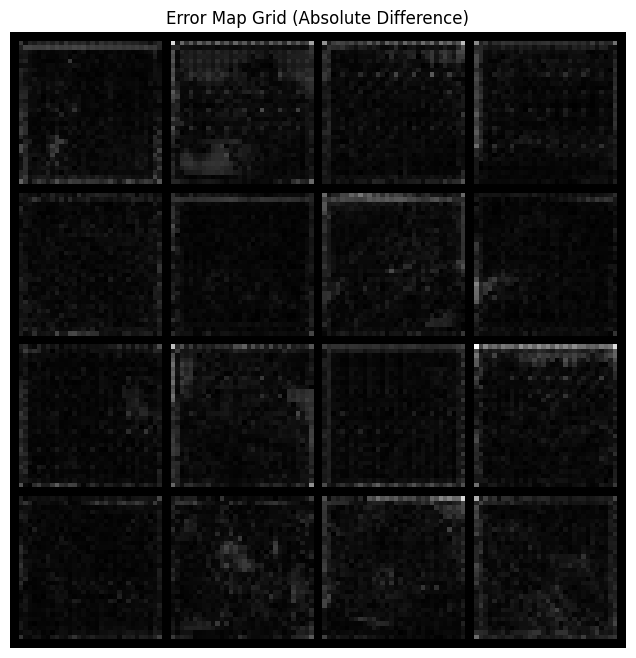

In [13]:
import torch
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

# Calculate absolute error map (grayscale)
error_map = torch.abs(imgs_vis - recon_zlib).mean(dim=1, keepdim=True)  # [B,1,H,W]

# Save error map images grid
save_image(error_map, "output_images/error_map.png")
print("Saved error map image.")

# Display error map grid using matplotlib
grid_img = make_grid(error_map, nrow=4, normalize=True)  # Normalize for better visibility

plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')
plt.title("Error Map Grid (Absolute Difference)")
plt.show()


In [14]:
wandb.log({
    "eval/rate_distortion_point": wandb.plot.scatter(
        wandb.Table(data=[[compressed_size_kb, -psnr_compressed]], columns=["Compressed Size (KB)", "-PSNR"]),
        "Compressed Size (KB)",
        "-PSNR",
        title="Rate-Distortion Curve (Negative PSNR)"
    )
})



In [15]:
wandb.log({
    "compression/psnr": psnr_compressed.item(),
    "compression/size_kb": compressed_size_kb,
    "compression/error_map": wandb.Image(grid, caption="|Original - CompressedRecon| x5")
})


In [16]:
!pip install pytorch-msssim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import time
from pytorch_msssim import ssim
import wandb
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Utilities ---
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2, reduction='mean')
    return float('inf') if mse.item() == 0 else (20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse)).item()

def calculate_bpp(compressed_bits, image_shape):
    batch_size, _, h, w = image_shape
    return compressed_bits / (batch_size * h * w)

def make_image_grid(imgs_list, nrow=4):
    """
    Make a grid of images side by side for comparison.
    imgs_list: list of torch.Tensor images [B, C, H, W]
    Returns: grid tensor with imgs concatenated side by side for each batch
    """
    # Assuming all imgs have shape [B,C,H,W]
    import torchvision.utils as vutils
    # Concatenate along width: stack images per sample horizontally, then stack vertically batches
    concatenated = torch.cat(imgs_list, dim=3)  # concat on width
    grid = vutils.make_grid(concatenated, nrow=nrow, normalize=True, scale_each=True)
    return grid

def get_error_map(img1, img2):
    """Absolute error per pixel, normalized to [0,1]"""
    err = torch.abs(img1 - img2)
    err = err / err.max()
    return err

# --- Setup ---
wandb.init(project="latent-compression", name="rd-curve-experiment-with-visuals")

autoencoder.eval()
latent_compressor.eval()

quant_levels = [64, 127, 255]
results = []

for quant in quant_levels:
    for imgs, _ in tqdm(testloader, desc=f"Quant={quant}"):
        imgs = imgs.to(device)

        with torch.no_grad():
            # --- AE encode and reconstruct ---
            e1 = autoencoder.enc1(imgs)
            e2 = autoencoder.enc2(e1)
            e3 = autoencoder.enc3(e2)
            z = latent_compressor.encoder(e3)
            z_quant = quantize(z)

            # Uncompressed AE reconstruction for baseline
            decoded_e3_ae = latent_compressor.decoder(z_quant)
            d1_ae = autoencoder.dec1(decoded_e3_ae)
            d2_ae = autoencoder.dec2(torch.cat([d1_ae, e2], dim=1))
            recon_ae = autoencoder.dec3(torch.cat([d2_ae, e1], dim=1))

            # Quantize to int8 using current quant level
            z_int = torch.clamp(torch.round(z_quant * quant), -quant, quant).to(torch.int8)
            z_np = z_int.cpu().numpy()

            # Compression
            start_c = time.time()
            zlib_compressed = zlib.compress(z_np.tobytes(), level=9)
            comp_time = (time.time() - start_c) * 1000

            # Decompression
            start_d = time.time()
            z_np_decomp = np.frombuffer(zlib.decompress(zlib_compressed), dtype=np.int8)
            decomp_time = (time.time() - start_d) * 1000

            z_t_decomp = torch.from_numpy(z_np_decomp.copy()).float() / quant
            z_t_decomp = z_t_decomp.view_as(z).to(device)

            # Decode compressed
            decoded_e3 = latent_compressor.decoder(z_t_decomp)
            d1 = autoencoder.dec1(decoded_e3)
            d2 = autoencoder.dec2(torch.cat([d1, e2], dim=1))
            recon = autoencoder.dec3(torch.cat([d2, e1], dim=1))

            # Metrics
            psnr_ae = calculate_psnr(imgs, recon_ae)
            psnr = calculate_psnr(imgs, recon)
            ssim_val = ssim(imgs, recon, data_range=1.0).item()
            bpp = calculate_bpp(len(zlib_compressed) * 8, imgs.shape)
            size_kb = len(zlib_compressed) / 1024
            original_kb = e3.nelement() * 4 / 1024  # float32
            ratio = original_kb / size_kb

            results.append({
                "quant_level": quant,
                "PSNR_AE": psnr_ae,
                "PSNR_Compressed": psnr,
                "SSIM": ssim_val,
                "BPP": bpp,
                "Compressed_KB": size_kb,
                "Original_KB": original_kb,
                "Compression_Ratio": ratio,
                "Compression_Time_ms": comp_time,
                "Decompression_Time_ms": decomp_time,
            })

            # Visual logging per batch: sample first 4 images to keep size reasonable
            imgs_viz = imgs[:4]
            recon_ae_viz = recon_ae[:4]
            recon_viz = recon[:4]

            # Create side-by-side grid: Original | AE Recon | Compressed Recon
            grid_img = make_image_grid([imgs_viz, recon_ae_viz, recon_viz], nrow=4)

            # Error map between Original and Compressed Recon
            error_map = get_error_map(imgs_viz, recon_viz)
            error_grid = make_image_grid([error_map], nrow=4)

            # Log images and scalars to WandB
            wandb.log({
                f"Visuals/Quant_{quant}/Image_Comparison": wandb.Image(grid_img, caption=f"Original | AE Recon | Compressed Recon (Quant {quant})"),
                f"Visuals/Quant_{quant}/Error_Map": wandb.Image(error_grid, caption=f"Error Map (Quant {quant})"),
                f"Metrics/Quant_{quant}/PSNR_AE": psnr_ae,
                f"Metrics/Quant_{quant}/PSNR_Compressed": psnr,
                f"Metrics/Quant_{quant}/SSIM": ssim_val,
                f"Metrics/Quant_{quant}/BPP": bpp,
                f"Metrics/Quant_{quant}/Compression_Time_ms": comp_time,
                f"Metrics/Quant_{quant}/Decompression_Time_ms": decomp_time,
            })

# Prepare WandB tables for RD plots
rd_table = wandb.Table(columns=["Quant", "BPP", "PSNR_Compressed", "SSIM", "Compression_Time_ms"])
for r in results:
    rd_table.add_data(r["quant_level"], r["BPP"], r["PSNR_Compressed"], r["SSIM"], r["Compression_Time_ms"])

wandb.log({
    "RD_Curve_PSNR": wandb.plot.line(rd_table, "BPP", "PSNR_Compressed", title="Rate–Distortion: PSNR"),
    "RD_Curve_SSIM": wandb.plot.line(rd_table, "BPP", "SSIM", title="Rate–Distortion: SSIM"),
    "Compression_Time_vs_BPP": wandb.plot.line(rd_table, "BPP", "Compression_Time_ms", title="Compression Time vs BPP"),
})

# Save CSV for reporting
df = pd.DataFrame(results)
df.to_csv("output_images/rate_distortion_metrics.csv", index=False)

# Print markdown table for quick report copy-paste
print("\n### Rate-Distortion Metrics Table (Markdown)\n")
print("| Quant Level | BPP | PSNR (Compressed) | SSIM | Compression Ratio | Comp Time (ms) | Decomp Time (ms) |")
print("|-------------|-----|-------------------|------|-------------------|---------------|------------------|")
for r in results:
    print(f"| {r['quant_level']} | {r['BPP']:.4f} | {r['PSNR_Compressed']:.2f} | {r['SSIM']:.4f} | {r['Compression_Ratio']:.2f} | {r['Compression_Time_ms']:.2f} | {r['Decompression_Time_ms']:.2f} |")




compression/psnr,▁
compression/size_kb,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
eval/bpp,▁
eval/compressed_latent_size_kb,▁
eval/compression_ratio,▁
eval/compression_time_ms,▁
eval/decompression_time_ms,▁
eval/original_latent_size_kb,▁
eval/psnr_compressed,▁
eval/psnr_reconstruction,▁


Quant=255: 100%|██████████| 625/625 [00:15<00:00, 39.39it/s]



### Rate-Distortion Metrics Table (Markdown)

| Quant Level | BPP | PSNR (Compressed) | SSIM | Compression Ratio | Comp Time (ms) | Decomp Time (ms) |
|-------------|-----|-------------------|------|-------------------|---------------|------------------|
| 64 | 0.1416 | 32.10 | 0.9895 | 3615.78 | 1.20 | 0.05 |
| 64 | 0.1523 | 31.33 | 0.9888 | 3360.82 | 1.29 | 0.04 |
| 64 | 0.1294 | 31.39 | 0.9907 | 3956.89 | 0.97 | 0.03 |
| 64 | 0.1367 | 32.12 | 0.9909 | 3744.91 | 1.36 | 0.04 |
| 64 | 0.1392 | 30.79 | 0.9889 | 3679.21 | 1.11 | 0.04 |
| 64 | 0.1299 | 31.43 | 0.9898 | 3942.02 | 1.02 | 0.03 |
| 64 | 0.1685 | 29.06 | 0.9861 | 3039.35 | 1.39 | 0.03 |
| 64 | 0.1401 | 32.28 | 0.9906 | 3653.57 | 1.27 | 0.04 |
| 64 | 0.1338 | 30.39 | 0.9900 | 3826.92 | 1.05 | 0.05 |
| 64 | 0.1543 | 31.70 | 0.9923 | 3318.28 | 1.19 | 0.03 |
| 64 | 0.1348 | 31.75 | 0.9922 | 3799.19 | 1.05 | 0.05 |
| 64 | 0.1348 | 29.96 | 0.9871 | 3799.19 | 1.39 | 0.06 |
| 64 | 0.1357 | 32.04 | 0.9903 | 3771.86 | 0.91 | 0.03 |
| 6

In [18]:
df.to_csv("rate_distortion_metrics.csv", index=False)

In [19]:
import pandas as pd

# Load the data
df = pd.read_csv("rate_distortion_metrics.csv")

# Display column names to check
print(df.columns)

# Group by 'quant_level' and calculate mean and std for relevant columns
summary = df.groupby('quant_level').agg({
    'BPP': ['mean', 'std'],
    'PSNR_Compressed': ['mean', 'std'],
    'SSIM': ['mean', 'std'],
    'Compression_Ratio': ['mean', 'std'],
    'Compression_Time_ms': ['mean', 'std'],
    'Decompression_Time_ms': ['mean', 'std']
}).reset_index()

# Flatten MultiIndex columns
summary.columns = ['_'.join(col).strip('_') for col in summary.columns.values]

print(summary)

# Optional: save summary to csv
summary.to_csv("summary_rate_distortion_metrics.csv", index=False)


Index(['quant_level', 'PSNR_AE', 'PSNR_Compressed', 'SSIM', 'BPP',
       'Compressed_KB', 'Original_KB', 'Compression_Ratio',
       'Compression_Time_ms', 'Decompression_Time_ms'],
      dtype='object')
   quant_level  BPP_mean   BPP_std  PSNR_Compressed_mean  PSNR_Compressed_std  \
0           64  0.138120  0.013725             31.358783             0.937374   
1          127  0.137407  0.013728             31.358783             0.937374   
2          255  0.137407  0.013728             31.147784             0.859030   

   SSIM_mean  SSIM_std  Compression_Ratio_mean  Compression_Ratio_std  \
0   0.989691  0.001863             3744.772525             386.640817   
1   0.989691  0.001863             3764.625159             390.813782   
2   0.988731  0.002328             3764.625159             390.813782   

   Compression_Time_ms_mean  Compression_Time_ms_std  \
0                  1.453016                 2.336660   
1                  0.693938                 0.191537   
2        

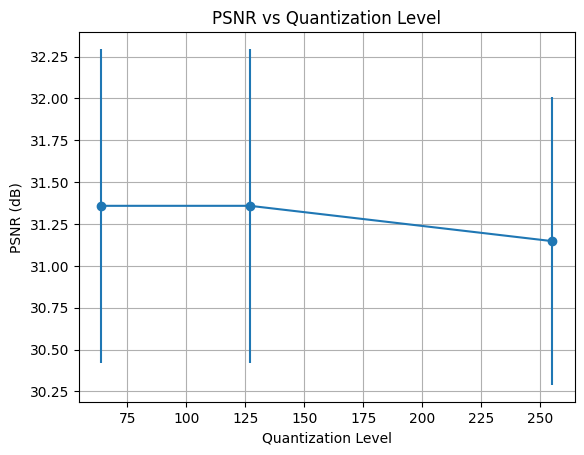

In [20]:
import matplotlib.pyplot as plt

plt.errorbar(summary['quant_level'], summary['PSNR_Compressed_mean'],
             yerr=summary['PSNR_Compressed_std'], label='PSNR', marker='o')
plt.xlabel('Quantization Level')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Quantization Level')
plt.grid(True)
plt.show()


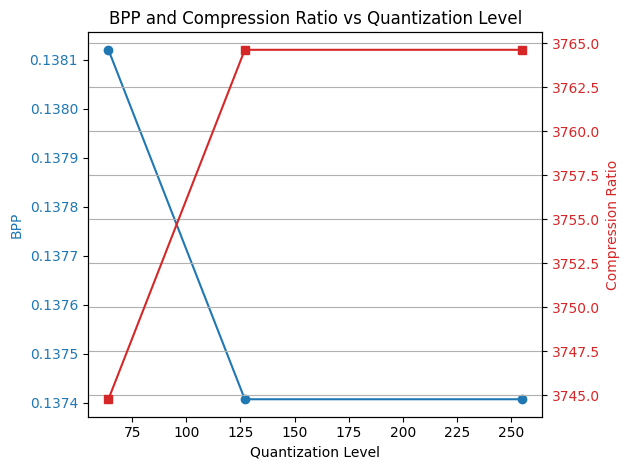

In [21]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Quantization Level')
ax1.set_ylabel('BPP', color=color)
ax1.plot(summary['quant_level'], summary['BPP_mean'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Compression Ratio', color=color)
ax2.plot(summary['quant_level'], summary['Compression_Ratio_mean'], color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("BPP and Compression Ratio vs Quantization Level")
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
from PIL import Image
import io
import os
import torch
import torchvision.transforms as T
import numpy as np

jpeg_results = []

jpeg_qualities = [10, 30, 50, 70, 90]

for q in jpeg_qualities:
    bpp_list, psnr_list = [], []

    for imgs, _ in testloader:
        imgs = imgs.to('cpu')  # Use CPU for PIL
        for img in imgs:
            img = T.ToPILImage()(img * 0.5 + 0.5)  # Unnormalize
            with io.BytesIO() as buffer:
                img.save(buffer, format='JPEG', quality=q)
                jpeg_bytes = buffer.getvalue()
                size_bytes = len(jpeg_bytes)

            # Decode
            with io.BytesIO(jpeg_bytes) as buffer:
                img_jpeg = Image.open(buffer)
                img_jpeg = T.ToTensor()(img_jpeg)

            # Crop or resize if needed to match original
            img_jpeg = img_jpeg[:3, :, :]
            img_tensor = (T.ToTensor()(img) * 0.5 + 0.5).clamp(0, 1)
            img_jpeg = img_jpeg.clamp(0, 1)

            # PSNR
            mse = F.mse_loss(img_jpeg, img_tensor)
            psnr = float('inf') if mse == 0 else 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse)
            psnr_list.append(psnr.item())

            # BPP = (bits / pixels)
            h, w = img_tensor.shape[1:]
            bpp = (size_bytes * 8) / (h * w)
            bpp_list.append(bpp)

        break  # Optional: test only on one batch

    jpeg_results.append({
        'quality': q,
        'bpp': np.mean(bpp_list),
        'psnr': np.mean(psnr_list)
    })


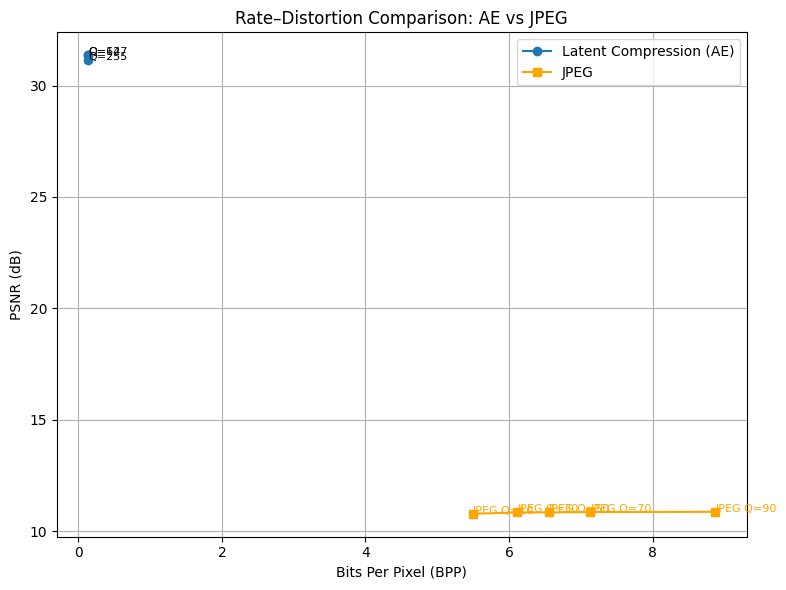

In [25]:
# Your AE model summary
ae_bpp = summary['BPP_mean']
ae_psnr = summary['PSNR_Compressed_mean']
ae_labels = summary['quant_level']

# JPEG data
jpeg_bpp = [r['bpp'] for r in jpeg_results]
jpeg_psnr = [r['psnr'] for r in jpeg_results]
jpeg_labels = [f'JPEG Q={r["quality"]}' for r in jpeg_results]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(ae_bpp, ae_psnr, '-o', label="Latent Compression (AE)")
plt.plot(jpeg_bpp, jpeg_psnr, '-s', label="JPEG", color='orange')

# Annotate points
for i, txt in enumerate(ae_labels):
    plt.annotate(f'Q={txt}', (ae_bpp[i], ae_psnr[i]), fontsize=8)

for i, txt in enumerate(jpeg_labels):
    plt.annotate(txt, (jpeg_bpp[i], jpeg_psnr[i]), fontsize=8, color='orange')

plt.xlabel("Bits Per Pixel (BPP)")
plt.ylabel("PSNR (dB)")
plt.title("Rate–Distortion Comparison: AE vs JPEG")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("rd_curve_ae_vs_jpeg.png")
plt.show()


In [23]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive("output_images", 'zip', "output_images")

# Download the zip file
files.download("output_images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>